# Learn to Combine Predictions With Stacked Generalization Ensemble

Model averaging is an ensemble technique where multiple submodels contribute equally to a combined prediction. Model averaging can be improved by weighting the contributions of each submodel to the combined prediction by the expected performance of the submodel. This can be extended further by training an entirely new model to learn how to best combine the contributions from each submodel. This approach is called stacked generalization, or stacking for short, and can result in better predictive performance than any single contributing model. In this tutorial, you will discover how to develop a stacked generalization ensemble for deep learning neural networks. After completing this tutorial, you will know:

* Stacked generalization is an ensemble method where a new model learns how to best combine the predictions from multiple existing models.
* Developing a stacking model using neural networks as a submodel and a scikit-learn classifier as the meta-learner.
* How to develop a stacking model where neural network submodels are embedded in a larger stacking ensemble model for training and prediction.

## Stacked Generalization Ensemble

A model averaging ensemble combines the predictions from multiple trained models. A limitation of this approach is that each model contributes the same amount to the ensemble prediction, regardless of how well the model performed. A variation of this approach, called a weighted average ensemble, weighs the contribution of each ensemble member by the trust or expected performance of the model on a hold-out dataset. This allows well-performing models to contribute more and less-well-performing models to contribute less. The weighted average ensemble provides an improvement over the model average ensemble.

A further generalization of this approach is replacing the linear weighted sum (e.g., linear regression) model used to combine the predictions of the submodels with any learning algorithm. This approach is called stacked generalization, or stacking for short. In stacking, an algorithm takes the outputs of submodels as input and attempts to learn how to combine the input predictions best to make a better output prediction. It may be helpful to think of the stacking procedure as having two levels: level 0 and level 1.

* Level 0: The level 0 data is the training dataset inputs, and level 0 models learn to make predictions from this data.
* Level 1: The level 1 data takes the output of the level 0 models as input, and the single level 1 model, or meta-learner, learns to make predictions from this data. 

Unlike a weighted average ensemble, a stacked generalization ensemble can use the set of predictions as a context and conditionally decide to weigh the input predictions differently, potentially resulting in better performance. Interestingly, although stacking is described as an ensemble learning method with two or more level 0 models, it can be used in the case of only a single level, 0 model. In this case, the level 1, or meta-learner, model corrects predictions from the level 0 model.

The meta-learner must be trained on a separate dataset to the examples used to train the level 0 models to avoid overfitting. A simple way that this can be achieved is by splitting the training dataset into a train and validation set. The level 0 models are then trained on the train set. The level 1 model is then trained using the validation set, where the raw inputs are first fed through the level 0 models to get predictions that are used as inputs to the level 1 model. A limitation of the hold-out validation set approach to training a stacking model is that level 0, and level 1 models are not trained on the full dataset.

A more sophisticated approach to training a stacked model involves using k-fold cross-validation to develop the training dataset for the meta-learner model. Each level 0 model is trained using k-fold cross-validation (or even leave-one-out cross-validation for maximum effect); the models are then discarded, but the predictions are retained. This means for each model, there are predictions made by a version of the model that was not trained on those examples, e.g., having hold-out examples, but in this case for the entire training dataset. The predictions are then used as inputs to train the meta-learner. Level 0 models are then trained on the entire training dataset, and together with the meta-learner, the stacked model can be used to make predictions on new data. In practice, it is common to use different algorithms to prepare each of the level 0 models to provide a diverse set of predictions.

It is also common to use a simple linear model to combine the predictions. Because the use of a linear model is common, stacking is more recently referred to as model blending or simply blending, especially in machine learning competitions.

A stacked generalization ensemble can be developed for regression and classification problems. In the case of classification problems, better results have been seen when using the prediction of class probabilities as input to the meta-learner instead of class labels.

Now that we are familiar with stacked generalization, we can develop a stacked deep learning model through a case study.

## Stacked Generalization Ensemble Case Study

In this section, we will demonstrate how to use the stacking ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the stacking ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the stacking ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

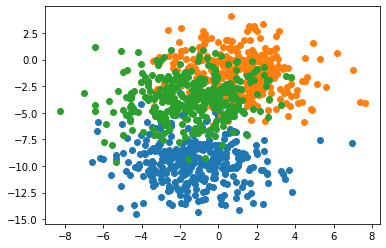

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for the stacking ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 500 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [5]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 98ms/step - loss: 2.2156 - accuracy: 0.2608 - val_loss: 2.1241 - val_accuracy: 0.3560
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 2.1970 - accuracy: 0.2446 - val_loss: 2.0144 - val_accuracy: 0.3440
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 2.1160 - accuracy: 0.2467 - val_loss: 1.9098 - val_accuracy: 0.3380
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 1.9762 - accuracy: 0.2872 - val_loss: 1.8095 - val_accuracy: 0.3320
Epoch 5/500
4/4 [==============================] - 0s 17ms/step - loss: 1.9046 - accuracy: 0.2372 - val_loss: 1.7155 - val_accuracy: 0.3300
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 1.7538 - accuracy: 0.2806 - val_loss: 1.6263 - val_accuracy: 0.3260
Epoch 7/500
4/4 [==============================] - 0s 15ms/step - loss: 1.7157 - accuracy: 0.2953 - val_loss: 1.5421 - val_accuracy: 0.3230
Epoch 8/500
4/4 [===

4/4 [==============================] - 0s 15ms/step - loss: 0.7044 - accuracy: 0.6541 - val_loss: 0.7021 - val_accuracy: 0.6690
Epoch 60/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6460 - accuracy: 0.6895 - val_loss: 0.6986 - val_accuracy: 0.6690
Epoch 61/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6202 - accuracy: 0.6897 - val_loss: 0.6948 - val_accuracy: 0.6730
Epoch 62/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6372 - accuracy: 0.6845 - val_loss: 0.6911 - val_accuracy: 0.6770
Epoch 63/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6500 - accuracy: 0.7017 - val_loss: 0.6876 - val_accuracy: 0.6820
Epoch 64/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6066 - accuracy: 0.7370 - val_loss: 0.6846 - val_accuracy: 0.6870
Epoch 65/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6145 - accuracy: 0.7382 - val_loss: 0.6819 - val_accuracy: 0.6870
Epoch 66/500
4/4 [========

4/4 [==============================] - 0s 15ms/step - loss: 0.5059 - accuracy: 0.7781 - val_loss: 0.6006 - val_accuracy: 0.7170
Epoch 118/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5288 - accuracy: 0.7655 - val_loss: 0.5989 - val_accuracy: 0.7180
Epoch 119/500
4/4 [==============================] - 0s 17ms/step - loss: 0.5453 - accuracy: 0.7561 - val_loss: 0.5968 - val_accuracy: 0.7200
Epoch 120/500
4/4 [==============================] - 0s 17ms/step - loss: 0.5514 - accuracy: 0.7498 - val_loss: 0.5948 - val_accuracy: 0.7220
Epoch 121/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4986 - accuracy: 0.7740 - val_loss: 0.5927 - val_accuracy: 0.7240
Epoch 122/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5135 - accuracy: 0.7561 - val_loss: 0.5917 - val_accuracy: 0.7230
Epoch 123/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5218 - accuracy: 0.7540 - val_loss: 0.5902 - val_accuracy: 0.7260
Epoch 124/500
4/4 [=

Epoch 175/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4413 - accuracy: 0.8313 - val_loss: 0.5345 - val_accuracy: 0.7700
Epoch 176/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4619 - accuracy: 0.8157 - val_loss: 0.5337 - val_accuracy: 0.7700
Epoch 177/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4593 - accuracy: 0.8065 - val_loss: 0.5325 - val_accuracy: 0.7720
Epoch 178/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4557 - accuracy: 0.8210 - val_loss: 0.5324 - val_accuracy: 0.7710
Epoch 179/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4505 - accuracy: 0.8084 - val_loss: 0.5324 - val_accuracy: 0.7710
Epoch 180/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4280 - accuracy: 0.8230 - val_loss: 0.5309 - val_accuracy: 0.7710
Epoch 181/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4808 - accuracy: 0.8002 - val_loss: 0.5266 - val_accuracy: 0.7760
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4100 - accuracy: 0.8332 - val_loss: 0.4889 - val_accuracy: 0.8000
Epoch 234/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4489 - accuracy: 0.7811 - val_loss: 0.4889 - val_accuracy: 0.8010
Epoch 235/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4222 - accuracy: 0.8207 - val_loss: 0.4895 - val_accuracy: 0.8010
Epoch 236/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4237 - accuracy: 0.8238 - val_loss: 0.4902 - val_accuracy: 0.8010
Epoch 237/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4148 - accuracy: 0.8124 - val_loss: 0.4907 - val_accuracy: 0.8000
Epoch 238/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4002 - accuracy: 0.8362 - val_loss: 0.4918 - val_accuracy: 0.7970
Epoch 239/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4194 - accuracy: 0.8216 - val_loss: 0.4926 - val_accuracy: 0.7970
Epoch 

Epoch 291/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4021 - accuracy: 0.8032 - val_loss: 0.4693 - val_accuracy: 0.8010
Epoch 292/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3905 - accuracy: 0.8063 - val_loss: 0.4698 - val_accuracy: 0.7990
Epoch 293/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3827 - accuracy: 0.8063 - val_loss: 0.4709 - val_accuracy: 0.8000
Epoch 294/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3823 - accuracy: 0.8145 - val_loss: 0.4724 - val_accuracy: 0.8020
Epoch 295/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3872 - accuracy: 0.8322 - val_loss: 0.4740 - val_accuracy: 0.8000
Epoch 296/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3929 - accuracy: 0.8247 - val_loss: 0.4751 - val_accuracy: 0.7980
Epoch 297/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3834 - accuracy: 0.8185 - val_loss: 0.4761 - val_accuracy: 0.8000
Epoch 

Epoch 349/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3844 - accuracy: 0.8124 - val_loss: 0.4596 - val_accuracy: 0.8070
Epoch 350/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3754 - accuracy: 0.7999 - val_loss: 0.4590 - val_accuracy: 0.8120
Epoch 351/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3432 - accuracy: 0.8395 - val_loss: 0.4587 - val_accuracy: 0.8110
Epoch 352/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3836 - accuracy: 0.8186 - val_loss: 0.4580 - val_accuracy: 0.8110
Epoch 353/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3350 - accuracy: 0.8591 - val_loss: 0.4571 - val_accuracy: 0.8100
Epoch 354/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3589 - accuracy: 0.8412 - val_loss: 0.4562 - val_accuracy: 0.8110
Epoch 355/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3599 - accuracy: 0.8330 - val_loss: 0.4558 - val_accuracy: 0.8110
Epoch 

Epoch 407/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3424 - accuracy: 0.8268 - val_loss: 0.4602 - val_accuracy: 0.8010
Epoch 408/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3460 - accuracy: 0.8495 - val_loss: 0.4596 - val_accuracy: 0.8010
Epoch 409/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3358 - accuracy: 0.8527 - val_loss: 0.4593 - val_accuracy: 0.8010
Epoch 410/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3152 - accuracy: 0.8662 - val_loss: 0.4599 - val_accuracy: 0.7990
Epoch 411/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3366 - accuracy: 0.8702 - val_loss: 0.4612 - val_accuracy: 0.7980
Epoch 412/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3502 - accuracy: 0.8586 - val_loss: 0.4619 - val_accuracy: 0.7990
Epoch 413/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3330 - accuracy: 0.8640 - val_loss: 0.4616 - val_accuracy: 0.8010
Epoch 

Epoch 465/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3134 - accuracy: 0.8579 - val_loss: 0.4535 - val_accuracy: 0.8110
Epoch 466/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3355 - accuracy: 0.8527 - val_loss: 0.4549 - val_accuracy: 0.8120
Epoch 467/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3302 - accuracy: 0.8454 - val_loss: 0.4559 - val_accuracy: 0.8120
Epoch 468/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3513 - accuracy: 0.8297 - val_loss: 0.4563 - val_accuracy: 0.8120
Epoch 469/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3453 - accuracy: 0.8433 - val_loss: 0.4555 - val_accuracy: 0.8130
Epoch 470/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3702 - accuracy: 0.8205 - val_loss: 0.4536 - val_accuracy: 0.8130
Epoch 471/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3336 - accuracy: 0.8485 - val_loss: 0.4521 - val_accuracy: 0.8140
Epoch 

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [6]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.860, Test: 0.799


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

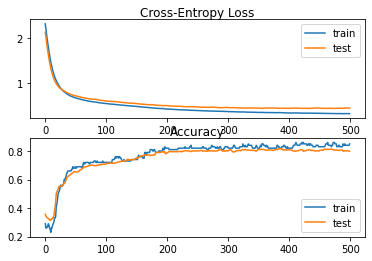

In [7]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [8]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.830, Test: 0.808


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 83% accuracy on the training dataset, which we know is optimistic, and about 81% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over the whole run, as we noted with the final scores.

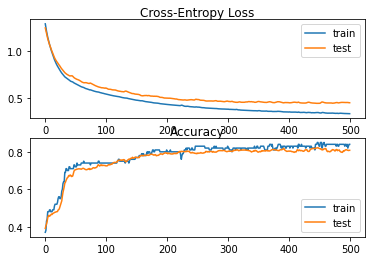

In [9]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

We can now look at using instances of this model as part of a stacking ensemble.

### Train and Save Sub-Models

### Separate Stacking Model

### Integrated Stacking Model

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Alternate Meta-Learner**. Update the example to use an alternate meta-learner classifier model to the logistic regression model.
* **Single Level 0 Model**. Update the example to use a single level-0 model and compare the results.
* **Vary Level 0 Models**. Develop a study demonstrating the relationship between test classification accuracy and the number of submodels used in the stacked ensemble.
* **Cross-Validation Stacking Ensemble**. Update the example to use k-fold cross-validation to prepare the training dataset for the meta-learner model.
* **Use Raw Input in Meta-Learner**. Update the example so that the meta-learner algorithms take the raw input data for the sample and the output from the submodels and compare performance.

## Summary

In this tutorial, you discovered how to develop a stacked generalization ensemble for deep learning neural networks. Specifically, you learned:

* Stacked generalization is an ensemble method where a new model learns how to best combine the predictions from multiple existing models.
* How to develop a stacking model using neural networks as a submodel and a scikit-learn classifier as the meta-learner.
* How to develop a stacking model where neural network submodels are embedded in a larger stacking ensemble model for training and prediction.